# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [1]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [2]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [3]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма распределения похожа на равномерное:

In [4]:
import matplotlib.pyplot as plt
plt.hist(random, normed=True)
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


<Figure size 640x480 with 1 Axes>

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

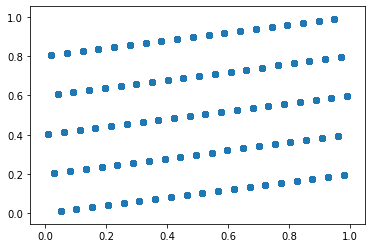

In [5]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

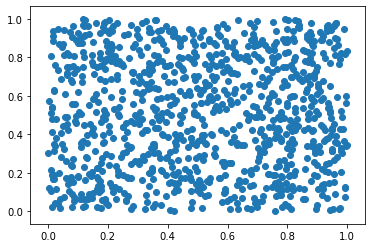

In [6]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline

In [8]:
def generate_discrete(weights, size):
    weights = weights / weights.sum()
    
    uniform = np.random.uniform(size=size)
    res = np.zeros(size)
    for i in range(uniform.size):
        cur_sum = 0
        for j in range(len(weights)):
            if weights[j] + cur_sum >= uniform.flat[i]:
                res.flat[i] = j
                break
            cur_sum += weights[j]
    return res


def generate_discrete_fast(weights, size):
    weights = weights / weights.sum()
    weights = list(enumerate(weights))
    weights.sort(key=itemgetter(1), reverse=True)
    
    uniform = np.random.uniform(size=size)
    res = np.zeros(size)
    for i in range(uniform.size):
        cur_sum = 0
        for number, weight in weights:
            if weight + cur_sum >= uniform.flat[i]:
                res.flat[i] = number
                break
            cur_sum += weight
    
    return res

(array([ 57., 156.,  85., 110., 153., 288.,  59.,   8.,   1.,  83.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

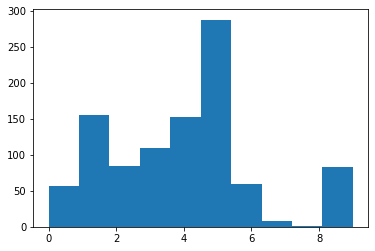

In [9]:
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
data = generate_discrete(weights, 1000)
plt.hist(data, bins=10)

(array([ 58., 164.,  74., 119., 158., 260.,  58.,   4.,   1., 104.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

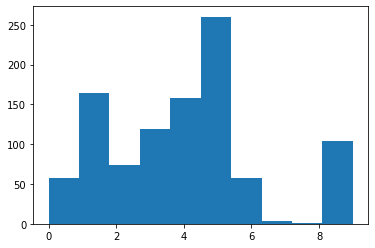

In [10]:
data = generate_discrete_fast(weights, 1000)
plt.hist(data, bins=10)

In [11]:
%time data = generate_discrete(weights, 10000)

CPU times: user 48.5 ms, sys: 1.58 ms, total: 50.1 ms
Wall time: 52.2 ms


In [12]:
%time data = generate_discrete_fast(weights, 10000)

CPU times: user 27.1 ms, sys: 1.48 ms, total: 28.6 ms
Wall time: 30.6 ms


Алгоритм с сортировкой работает почти в два раза быстрее.

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

Найдем обратную функцию распределения:
$$ F(x) = 1 - e^{-\lambda x} $$
$$ F^{-1}(x) = \frac{\ln{(1 - F(x))}}{-\lambda} $$

In [13]:
import scipy.stats

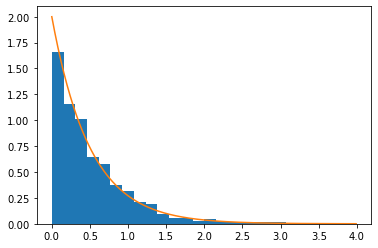

In [15]:
l = 2
uniform = np.random.uniform(size=1000)
exp = np.log(1 - uniform) / (-l)
plt.hist(exp, density=True, bins=20)

r = np.arange(0, 4, .01)
plt.plot(r, scipy.stats.expon.pdf(r, scale=1 / l))

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

Пусть мы хотим сгенерировать выборку из распределения с плотностью $ p $. Пусть мы можем генерировать выборку из распределения с плотностью $ q $ такого, что найдется константа $ C $, что $ p \leq C q $. Тогда метод accept-reject выглядит так: мы генерируем элемент $ x $ из $ q $, затем генериуем элемент $ y $ из равномерного распределения на отрезке $ [0, 1] $. Если $ y \leq \frac{p(x) }{C q(x)} $, то оставляем его, иначе повторяем процедуру заново. Проверим, что $ y $ имеет плотноть $ p $:

$$ P(y \leq t) = 

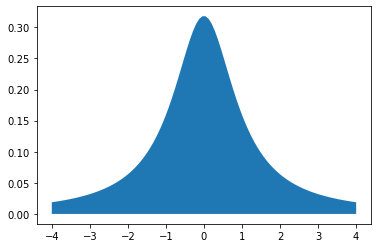

In [16]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

In [17]:
def truncated_cauchy(x, low, high):
    density = scipy.stats.cauchy.pdf(x)
    density[(x < low) | (x > high)] = 0
    density /= scipy.stats.cauchy.cdf(high) - scipy.stats.cauchy.cdf(low)
    return density

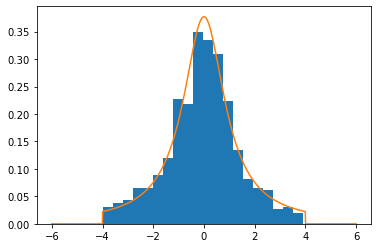

In [18]:
q = np.random.uniform(low=-4, high=4, size=5000)
p_density = truncated_cauchy(q, -4, 4)
q_density = scipy.stats.uniform.pdf(q, loc=-4, scale=8)
y = np.random.uniform(size=5000)
C = 4

p = q[y < p_density / (C * q_density)]
p = p[:1000]
plt.hist(p, density=True, bins=20)

r = np.linspace(-6, 6, 1000)
plt.plot(r, truncated_cauchy(r, -4, 4))

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

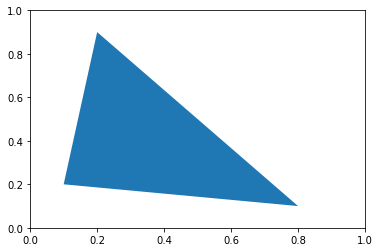

In [19]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

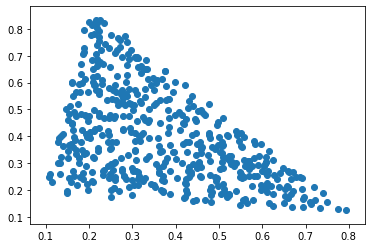

In [30]:
x = np.random.uniform(size=500)
y = np.random.uniform(size=500)

upper_mask = (x + y) > 1
x[upper_mask] = 1 - x[upper_mask]
y[upper_mask] = 1 - y[upper_mask]

x =  .7 * x + .1 * y + .1
y = -.1 * x + .7 * y + .2

plt.scatter(x, y)

### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

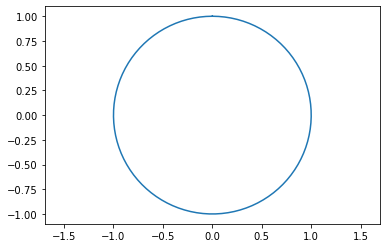

In [21]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

Подберем подходящие распределения на полярные координаты $ (r, \phi) $. $ \phi $ будем брать из равномерного распределения на $ [0, 2 \pi] $. Для того, чтобы получить равномерное распределение в круге нам достаточно, чтобы вероятность попадания в круг радиуса $ R $ была равна $ \frac{\pi R^2}{\pi 1^2} = R^2 $. То есть у $ r $ функция распределения $ x^2 $. Радиус будем генерировать методом inverse transform.

(-1.084156442351802,
 1.0819269193067365,
 -1.0842922078068638,
 1.0793668565650834)

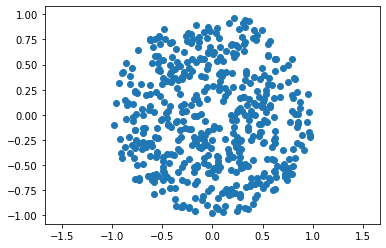

In [59]:
phi = np.random.uniform(low=0, high=2 * np.pi, size=500)
r = np.random.uniform(size=500)
r = np.sqrt(r)

plt.scatter(r * np.cos(phi), r * np.sin(phi))
plt.axis('equal')

### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

Для удобства перейдем из координат $ (x, y) $ в коодинаты $ (a, b) $, где $ a = x + y, b = x - y$. В новых координатах возможные действия следующие: $ (+1, +1), (+1, -1), (-1, +1), (-1, -1) $. Можем считать, что у нас есть два независимых случайных блуждания на прямой. В этой ситуации легко сгенерировать случайное блуждания с центром и концом в $ (0, 0) $: достаточно сгенерировать два одномерных случайных блуждание с началом и концом в 0, а для этого нужно лишь выбрать $ \frac{n}{2} $ плюс единиц из $ n $ ходов. Переход в исходные координаты: $ x = \frac{a + b}{2}, y = \frac{b - a}{2} $.

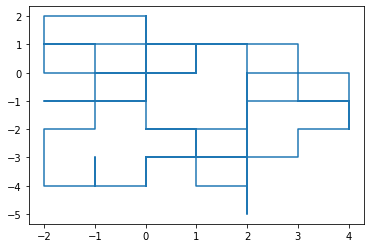

In [122]:
n = 100

a_minus_index = np.random.choice(np.arange(n), n // 2, replace=False)
b_minus_index = np.random.choice(np.arange(n), n // 2, replace=False)

a_steps = np.ones(n)
a_steps[a_minus_index] = -1

b_steps = np.ones(n)
b_steps[b_minus_index] = -1

a = np.cumsum(a_steps)
b = np.cumsum(b_steps)

x = (a + b) / 2
y = (b - a) / 2

plt.plot(x, y)

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модивицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

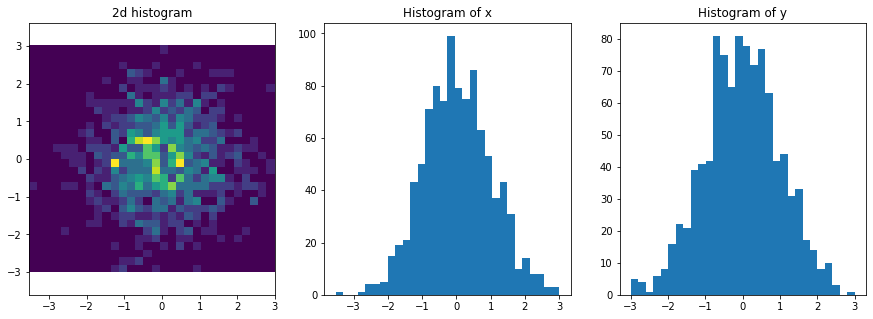

In [208]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

Пусть $ X, Y $ независимые нормальные случайные величины с дисперсией 1. При линейно замене с матрицей $ A $ матрица ковариаций $X, Y $ переходит в $ A^T A $. Нетрудно проверить, что требуемая матрица получается при $ A = \begin{pmatrix}
\frac{\sqrt{7}}{2} & \frac{1}{2} \\
0 & 2
\end{pmatrix}$. Для получения требуемого математического ожидание нужно просто его добавить.

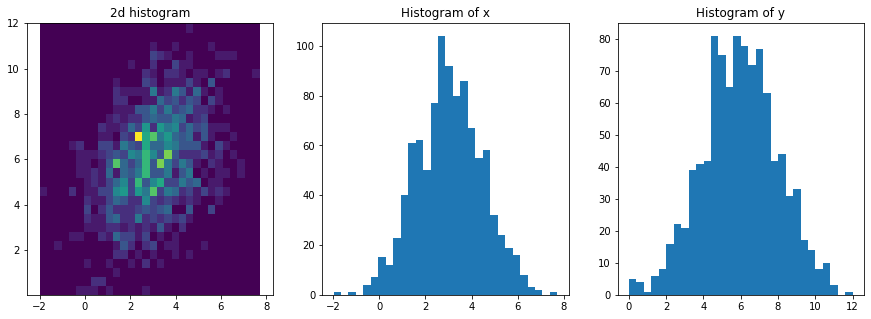

In [209]:
new_x = np.sqrt(7) / 2 * x + 1 / 2 * y + 3
new_y = 2 * y + 6

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(new_x, new_y, bins=30)
ax[0].axis('equal')
ax[1].hist(new_x, bins=30)
ax[2].hist(new_y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

In [211]:
np.mean(new_x), np.mean(new_y)

(3.0457526764770035, 5.97204447719269)

In [214]:
np.cov([new_x, new_y])

array([[2.00625654, 1.07479076],
       [1.07479076, 4.05320001]])

## Практическое задание

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов. 

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [444]:
def generate_partition(n, size):
    prob = np.zeros(n)
    
    fact = 1
    for i in range(n):
        fact *= (i + 1)
        prob[i] = (i + 1)**n / fact
    prob /= prob.sum()
    
    num_groups = np.random.choice(np.arange(1, n + 1), p=prob, size=size)
    ans = np.zeros((size, n))
    for i in range(size):
        ans[i, :] = np.random.choice(np.arange(1, num_groups[i] + 1), size=n)
    return ans

Математическое ожидание числа подмножеств в случайном разбиении множества из 100 элементов:

In [468]:
generate_partition(100, 10000).max(axis=1).mean()

29.5995